## Load data

In [1]:
import numpy as np
import _pickle as pkl
import torch
import torch.nn as nn
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)
from argparse import Namespace
import json
from utils2 import load_vh_models, frame_stack
from models import ProductOfExperts
import gzip

In [5]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({
 'res': 64,
#  'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
#                    .format("vha1_2D_len16_oscxy_withGT_0B7AB071F98942578ABDA66879290F2F.pkl"),
#                   '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
#                    .format("vha2_2D_len16_oscxy_withGT_3502DE81F7C343FB8B57FA92FDECF4DA.pkl"),
#                   '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
#                    .format("vha3_2D_len16_oscxy_withGT_5DB32B21A6AA4E5892D2F6B8F40EF9E6.pkl")
#                  ],
 'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/mit_push/{}'
                   .format("min-tr2.5_min-rot0.5_len48.pkl")
                 ],
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("mit"),
 'device': 'cuda:1',
 'n_examples': 4,
 'n_pred': 24,
 'n_initial': 2
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

def is_gz_file(filepath):
    with open(filepath, 'rb') as test_f:
        return test_f.read(2) == b'\x1f\x8b'
    
data = {
#     'img_rgb': [],
    'img_gray': [],
    'haptic': [],
    'arm': [],
    'actions': []
}

for dataset_path in args.dataset_path:
    if is_gz_file(dataset_path):
        with gzip.open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)
    else:
        with open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)

#     data['img_rgb'].append(torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device))
    data['img_gray'].append(torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device))
    data['haptic'].append(torch.from_numpy(raw_data['ft']).float().to(device=args.device))
    data['arm'].append(torch.from_numpy(raw_data['arm']).float().to(device=args.device))
    data['actions'].append(torch.from_numpy(raw_data["action"]).to(device=args.device).float())

data = {k:torch.cat(v, dim=0) for k,v in data.items()}

## Visualize

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487689_mit_nstep2_1024optbase_noAnnealkl_noWN_yesBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vh_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.31478727 0.34620175 0.33107433 0.33589277 0.2537887  0.38294443
 0.3867384  0.29631358 0.5548868  0.47412175 0.591187   0.5569411
 0.66994447 0.5925825  0.952853   0.8634874  0.80590034 0.8580537
 0.91741455 1.0949011  1.111302   1.1292675  1.1474515  1.3467748 ]


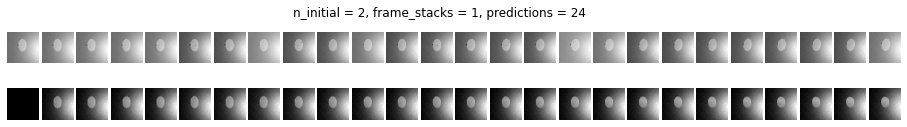

MSE of predictions:  [1.0155439  0.6928853  0.57461524 0.31920844 0.23071025 0.54544693
 0.48623058 0.44538194 0.47310734 0.2947019  0.1708892  0.17730977
 0.42139322 0.40623507 0.3860985  0.20767647 0.21822648 0.31314087
 0.26966578 0.27897528 0.7929849  0.6435496  0.3477105  0.35177377]


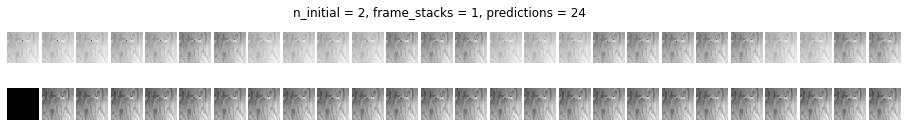

MSE of predictions:  [0.8604944  0.44505325 0.4557312  0.462279   0.5974202  0.93499374
 0.6085366  0.67051536 1.1509397  0.72808164 0.72548795 0.7266192
 0.70423317 0.86739945 0.9232109  1.1468356  1.7878532  1.3199887
 1.2976462  1.3439639  1.3624623  2.2204602  1.718281   1.7618407 ]


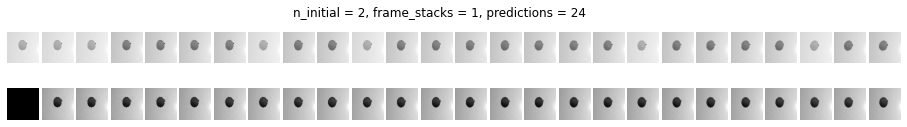

MSE of predictions:  [1.2251902  1.4837538  1.6553047  1.6759334  1.1580143  1.2430333
 1.1451617  0.95132077 1.035634   1.5889075  1.2399247  1.3638645
 1.5194285  1.3558798  1.5167098  1.45263    1.6552161  1.587214
 1.8248118  1.6466719  1.722459   2.0528798  2.407031   2.5330286 ]


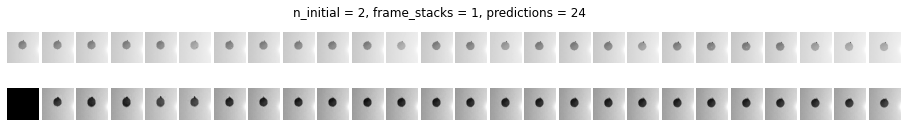

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487686_mit_nstep2_1024optbase_noAnnealkl_noWN_yesBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_va_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.4238378  0.44376856 0.49165735 1.1656479  1.2917485  1.0011362
 1.0468118  0.9039157  0.6302097  1.5754439  1.200365   0.8665999
 1.3326776  0.7163458  0.79767346 0.9557655  0.969921   1.6142792
 1.022712   1.0595343  1.1707797  1.3235865  1.9530466  1.1849068 ]


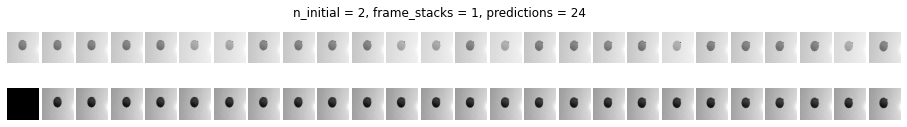

MSE of predictions:  [0.5078164  0.51211596 0.7681236  0.4641829  0.48071498 0.5238251
 1.4729431  1.090095   1.0135816  0.9756031  0.7394786  0.591412
 0.74010324 0.7198362  0.80557543 0.68284225 0.8387284  0.8308704
 1.3395839  1.0543425  0.9386317  0.976135   1.0002927  1.016451  ]


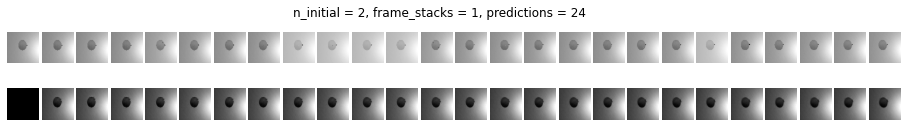

MSE of predictions:  [0.84396636 0.8601538  1.4217402  1.6428684  1.3121227  1.1015394
 0.92382044 1.4630198  1.5715253  1.6290905  1.52474    1.5022448
 1.2185502  1.8394079  2.0258315  1.8880699  1.8555983  2.0832815
 2.0684395  2.493444   3.2891955  2.9823442  3.5051425  2.8460503 ]


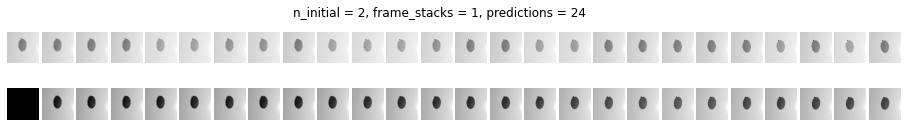

MSE of predictions:  [0.5548016  0.6501157  0.61346364 0.3135544  0.81249374 0.88791955
 0.6382225  0.49344945 0.5313947  0.54958093 1.0661606  1.1065793
 0.8519889  0.61977935 0.6452774  0.66675425 0.73077285 1.5272393
 1.2099494  1.2789893  1.1371782  1.1270618  0.7592354  0.88413525]


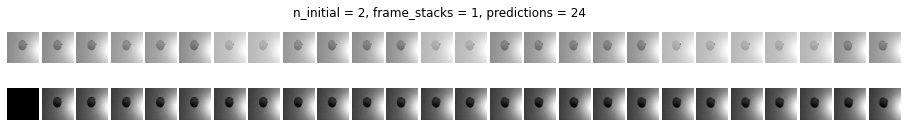

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487687_mit_nstep2_1024optbase_noAnnealkl_noWN_yesBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_v_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.9486582  0.99051684 1.033507   1.1077893  1.2150743  1.1823505
 1.5585155  1.2440115  1.4575455  1.0293453  1.0429747  1.6412393
 1.5799085  1.0972598  1.171179   1.0877934  1.4503818  1.4488581
 1.5654495  1.2683432  1.5922191  1.8066823  1.7061584  1.4367356 ]


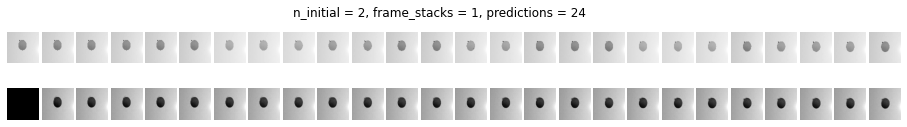

MSE of predictions:  [0.3551793  0.36052182 0.47870272 0.4864168  0.39250755 0.4022396
 0.40155804 0.68844426 0.55191886 0.5530127  0.6903135  0.85593134
 0.5422723  0.51788026 0.30885273 0.54867756 0.548387   0.43422943
 0.52422786 0.9662291  0.4630754  0.4644676  0.4665067  0.8812231 ]


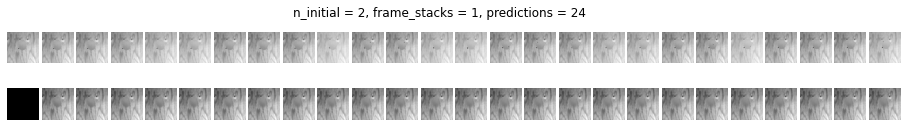

MSE of predictions:  [0.08554139 0.09369221 0.11777903 0.42523554 0.44141844 0.55174065
 0.7096335  0.40515786 0.2747196  0.32072094 0.29973307 0.2692172
 0.29518276 0.31801116 0.33994788 0.5810585  0.32571363 0.3508392
 0.4029981  0.50496733 0.4907446  0.562381   0.47807384 0.46606588]


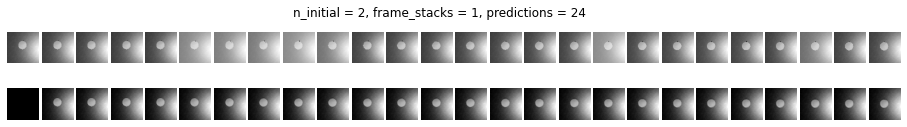

MSE of predictions:  [0.9590468  0.9756192  0.9789711  0.556482   0.5404215  0.50842035
 0.301725   0.5793845  0.87548995 0.436252   1.0638628  0.41177148
 0.4168899  0.4338576  0.44953167 0.683345   0.43122622 0.43877244
 0.46324784 0.51627624 0.6671686  0.52078897 0.52322483 0.5281807 ]


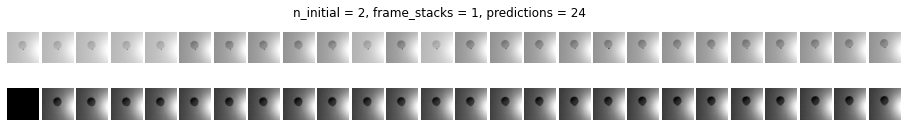

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487684_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vha_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.54227734 0.5800008  0.8192865  0.68887484 0.71927863 0.7649248
 0.69171906 0.748203   0.7557534  1.0328746  0.96441203 0.8179399
 0.86610746 0.6959437  0.86851096 0.73742795 0.7194187  0.6564981
 0.62702656 0.65277135 0.7014309  0.8668608  0.88015753 0.9760982 ]


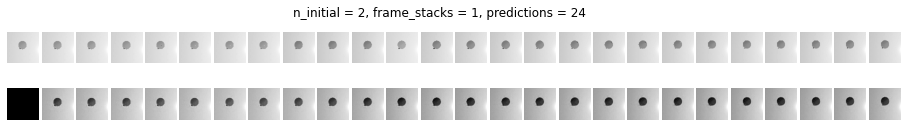

MSE of predictions:  [0.444429   0.6194396  0.79542613 1.0202371  0.79735935 0.42654723
 0.46643245 0.57881814 0.89503294 0.49622962 0.49938685 0.7671614
 0.7744222  0.77578866 0.7770602  0.63439786 1.0459993  0.95240015
 0.8995615  0.88326657 1.0189717  1.4414904  1.2015591  0.90902215]


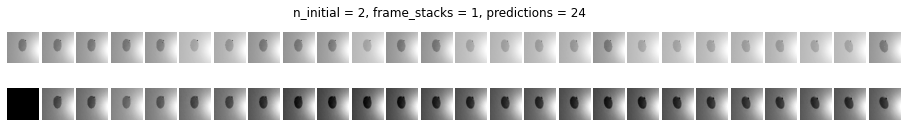

MSE of predictions:  [0.39938378 0.5125155  0.35169354 0.35393995 0.36713737 0.21680024
 0.19831288 0.53600705 0.2533613  0.27082163 0.24312562 0.2282748
 0.23333728 0.29866984 0.30444986 0.26976296 0.22298837 0.20423171
 0.21181852 0.25712103 0.29576463 0.32203764 0.25109452 0.22605886]


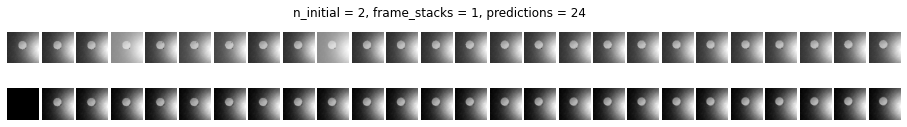

MSE of predictions:  [0.50675654 0.46843946 0.9343559  0.3333685  0.3309771  0.7194921
 0.28216454 0.7570738  0.3947194  0.3894924  0.39383647 0.38665268
 0.4125802  0.42554444 1.261606   0.5429954  0.5644593  0.5738579
 0.6922789  0.5786901  0.7442066  0.7629847  0.9595975  1.1591699 ]


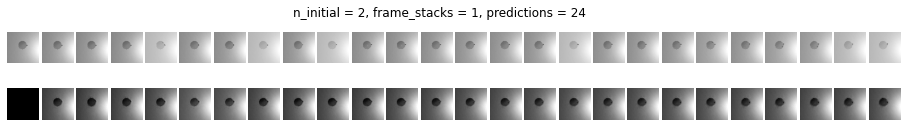

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487679_mit_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_v_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.36521575 0.34684104 0.41976872 0.6927346  0.67329    1.1536722
 1.1475807  0.49273002 0.36080402 0.37614122 0.68725586 0.6636202
 0.81087875 0.640805   0.8719295  0.54467463 0.48690543 0.42723274
 0.90234995 0.7771489  0.4262184  0.41668993 0.43105167 0.3079589 ]


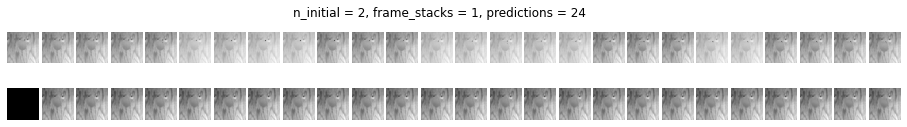

MSE of predictions:  [0.35598528 0.8375979  0.9392899  0.4613986  0.33955878 0.19738956
 0.6145426  0.5833888  0.6841358  0.646718   0.8311879  0.6634263
 0.75404924 0.7391937  1.3085321  1.2873597  0.47234973 0.39129776
 0.39708278 0.40359578 0.5343695  0.40637678 0.5531684  0.294756  ]


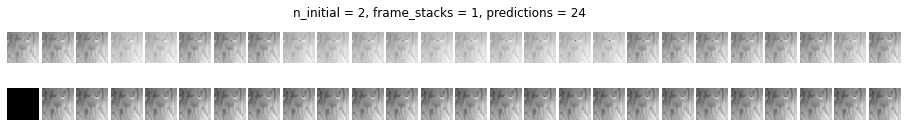

MSE of predictions:  [0.53935474 0.6466388  0.79368776 0.9127205  0.60768986 0.94981575
 1.0131899  0.8934036  0.99295753 0.72400594 0.9584147  1.1489112
 0.8888574  0.904542   0.6652533  0.73471606 1.4612538  0.9531143
 1.2644968  1.3899018  1.1612278  1.0297396  1.1245636  1.372091  ]


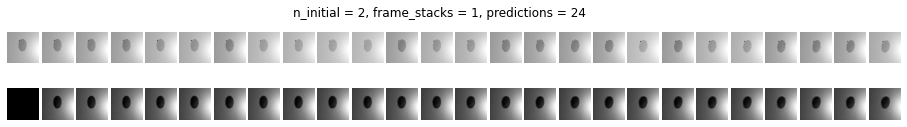

MSE of predictions:  [0.19800885 0.1556032  0.17561015 0.32014823 0.32842305 0.52664155
 0.5959471  0.62037057 0.6915513  0.76856136 1.3888209  1.0365776
 1.1029361  1.081209   1.2247623  1.389987   1.9880837  1.5942911
 1.7208965  1.648455   1.8188746  1.9216232  2.584947   2.326738  ]


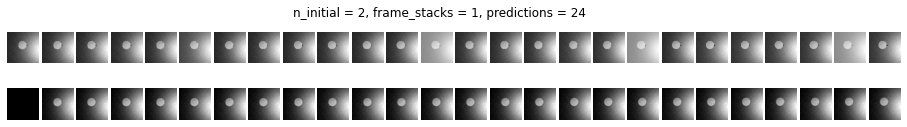

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487683_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_v_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.8022977  0.8270343  1.0248023  0.75085783 1.178612   1.2326714
 1.445869   1.6504627  1.4823008  1.5801564  1.8800365  1.9749641
 1.810234   2.062436   2.3066134  2.6188097  2.2499094  2.727678
 3.263752   3.8710425  3.7539377  3.9871416  3.860464   3.8042698 ]


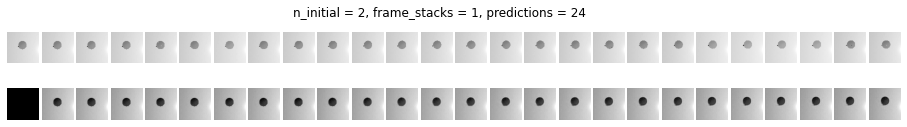

MSE of predictions:  [0.77976817 1.0525154  1.627062   1.5548689  1.9413888  1.8447506
 2.4314408  3.0136535  2.9737792  3.2044902  3.927436   3.5640802
 4.062021   4.1483717  4.589855   5.1557646  5.4556026  5.8154936
 6.322503   6.442586   6.9821386  6.9312778  7.1434827  7.5327635 ]


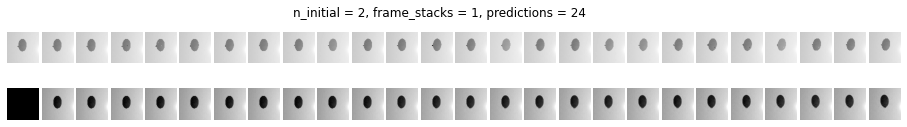

MSE of predictions:  [0.8098813  1.0483285  0.6631666  0.2807809  0.29637456 0.18317711
 0.65192866 0.40865177 0.28751662 0.30418995 0.78466594 0.29368716
 0.3069499  0.75222176 0.75585747 0.3054587  0.3210618  0.32648635
 0.24492726 0.25272763 0.71471834 0.43782103 0.5538882  0.43941653]


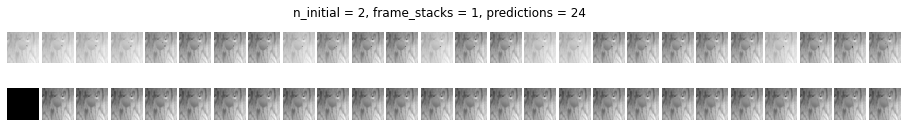

MSE of predictions:  [0.11502142 0.1074837  0.53065634 0.2088192  0.29389513 0.37481195
 0.87684065 0.93993235 0.949232   0.7209779  1.2104669  0.8776455
 0.80042565 0.7996259  0.9059576  1.4213921  1.1565113  1.0864651
 1.1561477  1.2067424  1.6705642  1.3859982  1.4066668  1.3410434 ]


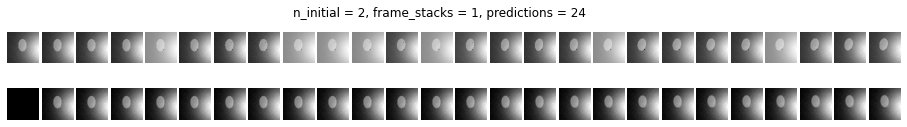

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487685_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vh_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.60813606 0.6523099  0.6062569  0.6236699  1.024423   0.78473544
 0.84136677 0.8573679  1.4254441  1.4487792  1.3901237  0.9073924
 1.5952291  1.411561   1.5017009  1.5033517  1.3033354  1.3324502
 1.3699498  1.7166603  1.864451   1.6527126  1.6777179  1.5700929 ]


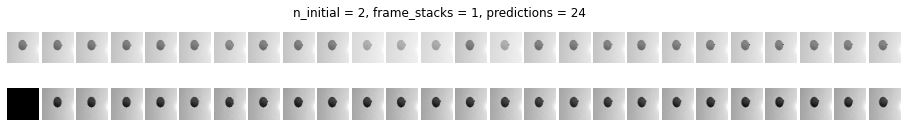

MSE of predictions:  [0.37960202 0.37076107 1.0387781  0.9220192  1.8205186  1.1854911
 1.1950696  1.2902119  1.0429599  1.4340845  1.1882329  1.2246337
 1.4955271  1.6665447  1.7384448  1.8733864  2.0247989  2.5363612
 2.583294   2.6327872  2.895824   2.8532352  3.2883205  3.3307176 ]


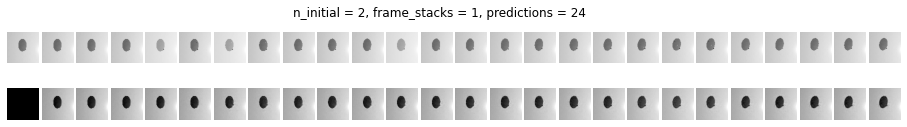

MSE of predictions:  [0.27987534 0.22401132 0.18144369 0.4123847  0.37488338 0.256006
 0.21123871 0.2167352  0.1962879  0.40465134 0.51669693 0.31792107
 0.20730393 0.3894841  0.33586338 0.57760644 0.5090515  0.23630625
 0.24814793 0.46277303 0.47382733 0.5892853  0.34744155 0.3541419 ]


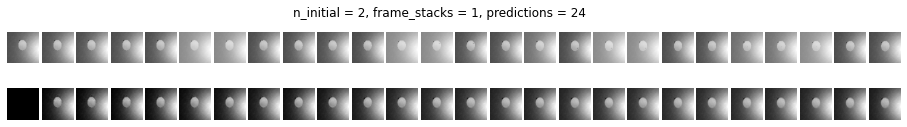

MSE of predictions:  [0.318672   0.3266995  0.3803114  0.5617818  1.3114429  1.1129159
 0.91733444 1.0007815  1.1173491  1.2423764  1.1510117  1.1073143
 1.4032497  1.1642667  1.2663136  1.3028866  1.3332345  1.5448346
 1.6507033  1.9576128  1.8482313  1.8325505  1.5974846  1.6104292 ]


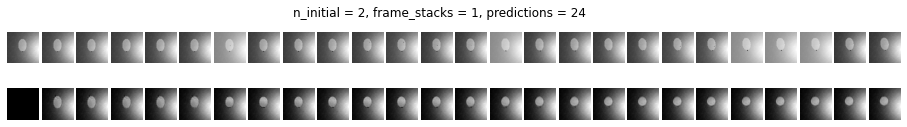

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487688_mit_nstep2_1024optbase_noAnnealkl_noWN_yesBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vha_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.09551837 0.10547478 0.48960564 0.46253303 0.20493472 0.2185078
 0.26843917 0.22842318 0.31419897 0.20884065 0.54960656 0.21594067
 0.23788905 0.27804157 0.3343956  0.28824455 0.3231619  0.38474014
 0.28430623 0.31810898 0.31910154 0.3548089  0.49816436 0.4644126 ]


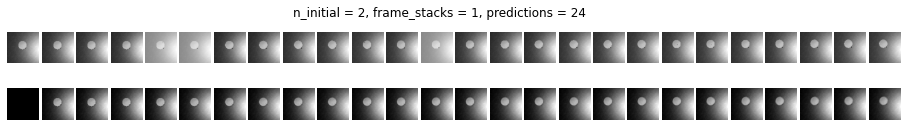

MSE of predictions:  [1.2237661  1.3093331  1.3136857  0.6314804  0.3132037  0.33268577
 0.70934105 0.7119101  0.30564398 0.30776137 0.21984953 0.22531241
 0.59976137 0.27464443 0.27071068 0.2736875  0.19587915 0.20151536
 0.6836117  0.27287355 0.27290136 0.2840175  0.30896226 0.32051456]


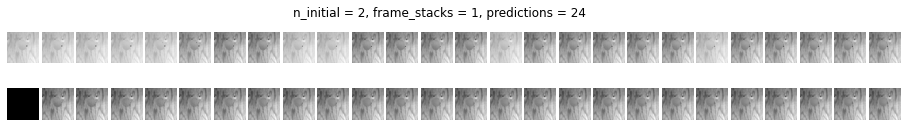

MSE of predictions:  [0.5560006  0.57671916 0.5990525  0.5976902  0.23755859 0.3369706
 0.8067899  0.44776738 0.6025059  0.46535772 0.47023317 0.4686029
 0.92708015 0.636993   0.4693757  0.43692195 0.42237473 0.4251439
 0.8910909  0.88042265 0.86240405 0.7519288  0.67500037 0.7640495 ]


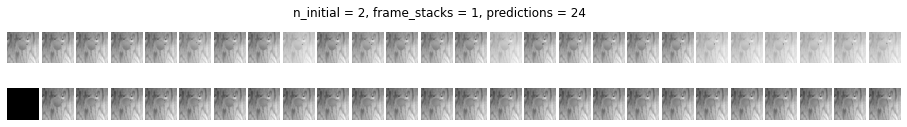

MSE of predictions:  [0.4831192  1.0316072  1.0778477  0.62094593 0.6258722  1.0789801
 0.9177469  0.87969863 0.8821087  0.6207442  1.1003357  1.0355489
 0.5362338  0.59270424 0.5759575  0.870911   0.8749407  0.6693454
 1.190645   0.65516514 0.64216363 0.64856774 1.0612595  0.70974773]


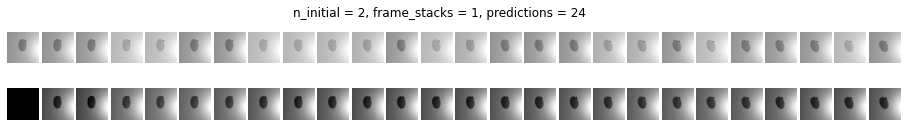

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487682_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_va_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.20006146 0.19867437 0.5590717  0.474961   0.5838275  0.73674166
 0.7662666  0.64774615 0.56856173 0.20820871 0.43580142 0.5756929
 0.49202988 0.74252594 0.60419333 0.35779935 0.36130106 0.80738467
 0.66341436 0.49130562 0.3899028  0.39114708 0.40445995 0.41629198]


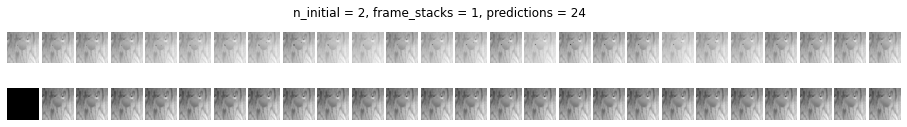

MSE of predictions:  [0.54773253 0.49332714 0.28310186 0.36499417 0.25309625 0.5020431
 0.25733703 0.2443079  0.6278098  0.52474415 0.2926916  0.32903543
 0.35484102 0.32009673 0.3157912  0.65741616 0.9809152  0.7493577
 0.4328231  0.44069862 0.44150746 0.462052   0.8060064  0.77233744]


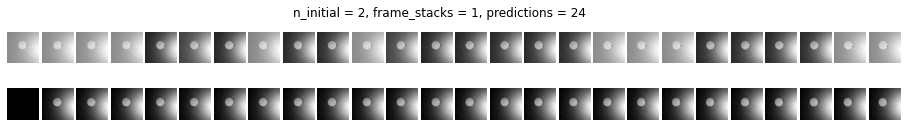

MSE of predictions:  [0.26550266 0.45613566 0.41295335 0.34306386 0.2454965  0.2577839
 0.27711368 0.249669   0.50075364 0.55382866 0.44467074 0.44316557
 0.416568   0.43846917 0.6916955  0.5202154  0.53689975 0.48634255
 0.39436394 0.39718148 0.5604632  0.5529854  0.472526   0.39065236]


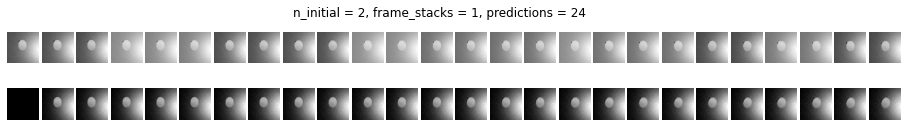

MSE of predictions:  [0.4944261  0.48351663 0.64267707 1.1199788  1.4046189  1.4116259
 1.9234002  1.5300634  1.9526365  2.4603453  2.5456724  2.6634564
 2.9147544  3.2293348  3.643845   3.9411936  4.076968   4.631858
 4.909216   4.973144   5.199585   5.541751   5.9726434  5.944437  ]


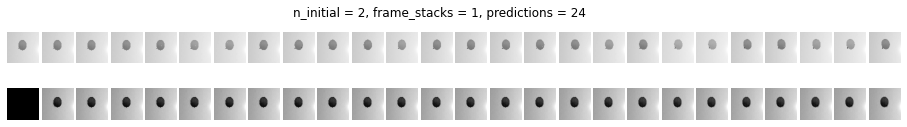

In [6]:
dict_of_models = load_models_dir(args.models_dir)

def list_diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

with torch.no_grad():
    for path, model_args in dict_of_models.items():
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)

        # Use validation indices only
        with open(os.path.join(path, "val_idx.pkl"), 'rb') as f:
            val_idx = pkl.load(f)
        data_val = {k:v[val_idx] for k,v in data.items()}
        
        if model_args.context_modality != "none":
            poe = ProductOfExperts()
        
#         if model_args.dim_x[0] == 1:
#             img_key = 'img_gray'
#         elif model_args.dim_x[0] == 3:
#             img_key = 'img_rgb'
        img_key = 'img_gray'
    
        T = model_args.frame_stacks
        
        assert args.n_initial + args.n_pred <= data_val[img_key].shape[1]
        assert args.n_initial > T

        # Use a random batch to test
        ii = np.random.randint(data_val[img_key].shape[0] // args.n_examples)
        batch_range = range(args.n_examples*ii, args.n_examples*(ii+1))
        test_batch = {k:v[batch_range] for k,v in data_val.items()}
        
        # Ground truth images and controls
        x_img = test_batch[img_key][:, :(args.n_initial + args.n_pred)]
        u = test_batch['actions']

        # Sequence of initial images
        x_img_i = x_img[:, :args.n_initial]
        x_img_i = frame_stack(x_img_i, frames=T)
        
        # Sequence of ground truth images
        x_img_gt = x_img[:, -(T + 1):]
        x_img_gt = frame_stack(x_img_gt, frames=T)
        
        # Sequence of extra modalities
        x_ft_i = test_batch['haptic'][:, T:args.n_initial] / model_args.ft_normalization
        x_arm_i = test_batch['arm'][:, T:args.n_initial]
        
        if model_args.context_modality == "joint":
            x_context_i = torch.cat((x_ft_i, x_arm_i), dim=-1).transpose(-1, -2)
        elif model_args.context_modality == "ft":
            x_context_i = x_ft_i.transpose(-1, -2)
        elif model_args.context_modality == "arm":
            x_context_i = x_arm_i.transpose(-1, -2)
                
        n, l = x_img_i.shape[0], x_img_i.shape[1] 
        
        # Encode
        z_img, mu_z_img, logvar_z_img = nets["img_enc"](x_img_i[:, 0])
        
        if model_args.context_modality != "none":
            _, mu_z_context, logvar_z_context = nets["context_enc"](x_context_i[:, 0])
            # Mix modalities with product of experts
            mu_z_obs_enc, logvar_z_obs_enc  = poe(
                mu=torch.cat((
                    mu_z_img.unsqueeze(1), 
                    mu_z_context.unsqueeze(1)
                ), axis=1),
                logvar=torch.cat((
                    logvar_z_img.unsqueeze(1), 
                    logvar_z_context.unsqueeze(1)
                ), axis=1), 
                prior=False
            )

            std_z_obs_enc = torch.exp(logvar_z_obs_enc / 2.0)
            eps = torch.randn_like(std_z_obs_enc)
            z_obs_enc = mu_z_obs_enc + eps * std_z_obs_enc
        else:
            # If only image is used
            z_obs_enc, mu_z_obs_enc, logvar_z_obs_enc = \
                z_img, mu_z_img, logvar_z_img
            
        if model_args.context == "none":
            # If only CNN is used for recognition, process in batch instead of roll out
            var_z_obs_enc = torch.diag_embed(torch.exp(logvar_z_obs_enc))
            # Group sample, mean, covariance
            q_z_i = {"z": z_obs_enc, "mu": mu_z_obs_enc, "cov": var_z_obs_enc}
        elif model_args.context == "ssm" or "rssm":
            q_z_i = {
                "z": torch.empty((n, l, model_args.dim_z), device=device),
                "mu": torch.empty((n, l, model_args.dim_z), device=device),
                "cov": torch.empty((n, l, model_args.dim_z, model_args.dim_z), device=device)
            }

            z_cat_enc = z_obs_enc.reshape(
                n, l, *z_obs_enc.shape[1:]
            ).transpose(1,0)

            z_0 =torch.zeros(
                model_args.dim_z, 
                requires_grad=False, 
                device=device
            ).repeat(n, 1)

            if model_args.context == "rssm":
                h_0 = None

            # Roll out
            for ii in range(l):
                if model_args.context == "ssm":
                    inp = z_0
                elif model_args.context == "rssm":
                    z_0 = z_0.unsqueeze(0)
                    out, h = nets["rssm_enc"](z_0, h_0)
                    inp = out[0]
                    h_0 = h

                z, mu_z, logvar_z = nets["mix"](
                    torch.cat((inp, z_cat_enc[ii]), axis=-1)
                )
                var_z = torch.diag_embed(torch.exp(logvar_z))
                q_z_i["z"][:, ii] = z 
                q_z_i["mu"][:, ii] = mu_z
                q_z_i["cov"][:, ii] = var_z
                z_0 = z

            q_z_i = {k:v.reshape(-1, *v.shape[2:]) for k, v in q_z.items()}
            
        # Group and prepare for prediction
        q_z_i = {k:v.reshape(n, l, *v.shape[1:]).transpose(1,0) for k, v in q_z_i.items()}
        u = u.transpose(1,0)

        z_hat = torch.zeros(((l + args.n_pred), n, model_args.dim_z)).to(device=args.device)
        z_hat[0:l] = q_z_i["mu"]
        
        # First run
        z_i, mu_z_i, var_z_i = q_z_i["z"], q_z_i["mu"], q_z_i["cov"]
        u_i = u[(T + 1):(1 + args.n_initial)]
        h_i = None

        # Predict
        for jj in range(0, args.n_pred):
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                z_t=z_i, 
                mu_t=mu_z_i, 
                var_t=var_z_i, 
                u=u_i, 
                h_0=h_i, 
                single=False
            )
            z_hat[jj + l] = mu_z_ip1[-1]
            z_i, mu_z_i, var_z_i, h_i = z_ip1[-1:], mu_z_ip1[-1:], var_z_ip1[-1:], h_ip1
            u_i = u[1 + args.n_initial + jj][None]
                        
        # Decode
        z_hat = z_hat.transpose(1, 0)
        x_hat = nets["img_dec"](z_hat.reshape(-1, *z_hat.shape[2:]))
        x_hat = x_hat.reshape(n, (l + args.n_pred), *x_hat.shape[1:])

        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x_img = x_img.cpu().numpy()

        mse = np.sum((x_hat[:, l:, 0].reshape(n, args.n_pred, -1) - 
                      x_img[:, args.n_initial:, 0].reshape(n, args.n_pred, -1))**2, axis=2)

        # Plotting
        for bb in range(n):
            columns = args.n_initial + args.n_pred
            rows = 2
            fig=plt.figure(figsize=(16, 2))
            fig.suptitle('n_initial = {}, frame_stacks = {}, predictions = {}'.format(args.n_initial, T, args.n_pred))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x_img[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((model_args.dim_x[1], model_args.dim_x[2]))
                    else:
                        img = x_hat[bb,idx-1,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                
                plt.axis('off')
            print("MSE of predictions: ", mse[bb])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            plt.show()